# **Part I: Hexapawn AI with Reinforcement Learning Implementation**

# Author: Ziwei Jin

## **1. Project Overview**

Hexapawn is a simplified chess game that serves as a great testbed for reinforcement learning algorithms. This project demonstrates how a Q-learning agent can learn to play Hexapawn through repeated simulations, refining its strategies based on rewards and penalties.

###    **1.1 Objectives**
        
The goal of this project is to develop an intelligent agent that learns to play Hexapawn using reinforcement learning techniques.
Specifically, we aim to:

1. Implement a complete Hexapawn game environment
2. Create a Q-learning agent that can learn optimal strategies
3. Demonstrate the agent's ability to improve its gameplay through training
4. Allow human interaction with the trained agent for testing.


###    **1.2 Background**

Hexapawn is a simplified chess-like game played on a 4x4 board with the following rules:

1. Each player starts with 4 pawns
2. Pawns can move forward or capture diagonally
3. Winning conditions:\
            -  Reach the opponent's first row\
            -  Eliminate all opponent's pawns\
            -  Block opponent from making a move

## **2. Implementation Architecture**


### **2.1. Reinforcement Learning Approach**
We utilized Q-learning, a model-free reinforcement learning algorithm, to train our Hexapawn agent. The key components of our approach include:

In [4]:
import numpy as np
import random

### **2.2. Key Class: HexapawnEnvironment**

    -  Manages game state
    -  Implements game rules
    -  Provides move validation
    -  Tracks game progression

**Board Setup:** A customizable N x N board is initialized with pawns for two players (White and Black).
    - White pawns: Represented by 1 and placed on the bottom row.
    - Black pawns: Represented by -1 and placed on the top row.

**Rules:**
Pawns move forward to an empty square.
Diagonal captures occur if an opponent's pawn is present.
Winning conditions:
    - A pawn reaches the opponent's back row.
    - The opponent has no valid moves.

In [6]:
class HexapawnEnvironment:

    
    def __init__(self, size=4):
        self.size = size
        self.reset()

    def reset(self):
        """Reset the board to initial state"""
        self.board = np.zeros((self.size, self.size), dtype=int)
        
        # Place white pawns at the bottom row
        for i in range(self.size):
            self.board[self.size-1][i] = 1
        
        # Place black pawns at the top row
        for i in range(self.size):
            self.board[0][i] = -1
        
        self.current_player = 1  # White starts
        return self._get_state()

    def _get_state(self):
        """Convert board to a hashable state"""
        return tuple(map(tuple, self.board))

    def choose_action(self, state, valid_moves):
        """
        Choose an action using epsilon-greedy strategy.
        """
        if not valid_moves:
            return None  # No valid moves available

        if random.random() < self.exploration_rate:
            return random.choice(valid_moves)

        # Exploit: choose the best move
        best_value = float('-inf')
        best_moves = []

        for move in valid_moves:
            q_value = self.get_q_value(state, move)
            if q_value > best_value:
                best_value = q_value
                best_moves = [move]
            elif q_value == best_value:
                best_moves.append(move)

        return random.choice(best_moves) if best_moves else random.choice(valid_moves)


    def get_valid_moves(self, player):
        """
        Generate all legal moves for a player
        - Forward movement
        - Diagonal captures
        """
        moves = []
        
        # Find all pawns of the current player
        pawn_positions = np.argwhere(self.board * player > 0)
        
        for py, px in pawn_positions:
            # Forward move
            forward_row = py - 1 if player == 1 else py + 1
            
            if 0 <= forward_row < self.size:
                if self.board[forward_row][px] == 0:
                    moves.append(((py, px), (forward_row, px)))
                else:
                    print(f"Blocked forward move for pawn at ({py}, {px}) -> ({forward_row}, {px})")
            else:
                print(f"Out-of-bounds forward move for pawn at ({py}, {px}) -> ({forward_row}, {px})")

            
            # Diagonal capture moves
            for dx in [-1, 1]:
                capture_row = py + player
                capture_col = px + dx
                
                # Check if diagonal move is within board and captures opponent
                if (0 <= capture_row < self.size and 
                    0 <= capture_col < self.size and 
                    self.board[capture_row][capture_col] * player < 0):
                    moves.append(((py, px), (capture_row, capture_col)))

        print(f"\nPlayer {player}'s valid moves: {moves}")
        return moves

    def step(self, move):
        """
        Execute a move and return new state, reward, and done flag
        """
        (start_y, start_x), (end_y, end_x) = move

        # Move the pawn
        self.board[end_y][end_x] = self.board[start_y][start_x]
        self.board[start_y][start_x] = 0

        # Check win conditions
        if self.current_player == 1 and any(self.board[0] == 1):
            return self._get_state(), 10, True  # White wins

        if self.current_player == -1 and any(self.board[self.size - 1] == -1):
            return self._get_state(), -10, True  # Black wins

        # Check if the opponent has no valid moves
        self.current_player *= -1
        valid_moves = self.get_valid_moves(self.current_player)
        if not valid_moves:
            reward = 10 if self.current_player == -1 else -10
            return self._get_state(), reward, True

        print(f"Executing move: {move}")
        print(f"Board after move:\n{self.board}")

        return self._get_state(), -0.1, False


### **2.3. Key Class: QLearningAgent**

    -  Maintains Q-table
    -  Implements action selection
    -  Updates state-action values
    -  Handles exploration vs exploitation

- **State representation:** Board configuration
- **Action space:** Valid pawn moves

#### **Parameters**
- **Learning Rate ($\alpha$)**: Adjusts the weight of new learning (default: 0.1).
- **Discount Factor ($\gamma$)**: Balances immediate vs. long-term rewards (default: 0.95).
- **Exploration Rate ($\epsilon$)**: Governs the exploration-exploitation trade-off (default: 0.1).

#### **Learning Mechanism**
- Updates Q-values using the Q-learning formula:
  $$
  Q(s, a) \leftarrow Q(s, a) + \alpha \left( r + \gamma \max_{a'}$ Q(s', a') - Q(s, a) \right)
  $$
- **Exploration vs. Exploitation**:
  - During exploration, the agent selects random actions to discover new strategies.
  - During exploitation, the agent chooses actions that maximize expected rewards based on learned Q-values.


In [8]:
class QLearningAgent:

    def __init__(self, size=4, learning_rate=0.1, discount_factor=0.95, exploration_rate=0.1):
        self.q_table = {}
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.size = size

    def get_q_value(self, state, move):
        """
        Get Q-value for a state-action pair
        """
        return self.q_table.get((state, move), 0.0)

    def choose_action(self, state, valid_moves):
        """
        Choose action using epsilon-greedy strategy
        """

        if not valid_moves:
            return None  # No valid moves available
            
        if random.random() < self.exploration_rate:
            return random.choice(valid_moves)
        
        # Exploit: choose the best move
        best_value = float('-inf')
        best_moves = []
        
        for move in valid_moves:
            q_value = self.get_q_value(state, move)
            if q_value > best_value:
                best_value = q_value
                best_moves = [move]
            elif q_value == best_value:
                best_moves.append(move)
        
        return random.choice(best_moves) if best_moves else random.choice(valid_moves)

    def learn(self, state, move, reward, next_state, valid_next_moves):
        """
        Q-learning update rule implementation
        - Calculate maximum future Q-value
        - Update current state-action value
        """
        # Calculate the maximum Q-value for the next state
        max_next_q_value = 0
        if valid_next_moves:
            max_next_q_value = max(
                self.get_q_value(next_state, next_move) 
                for next_move in valid_next_moves
            )
        
        # Q-learning update rule
        current_q = self.get_q_value(state, move)
        new_q = current_q + self.learning_rate * (
            reward + self.discount_factor * max_next_q_value - current_q
        )
        
        # Update Q-table
        self.q_table[(state, move)] = new_q

### **2.4. Training Process**

- **Episodes**: The agent is trained over 10,000 games.
- **Metrics**: Tracks win rates for both players to monitor progress.
- **Exploration Decay**: Reduces the exploration rate (\(\epsilon\)) over time, shifting focus from exploration to exploitation.
- **Reward structure:**

    1. +10 for winning
    2. -10 for losing
    3. -0.1 for continuing the game

In [9]:
def train_agent(num_episodes=10000):
    """
    Train the RL agent to play Hexapawn
    """
    env = HexapawnEnvironment()
    agent = QLearningAgent()
    
    white_wins = 0
    black_wins = 0
    
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        
        while not done:
            # Current player's turn
            current_player = env.current_player
            valid_moves = env.get_valid_moves(current_player)

            if not valid_moves:
                # No moves available; game over
                print(f"No valid moves for player {current_player} on board:\n{env.board}")
                reward = -10 if current_player == 1 else 10
                done = True
                break
            
            # Choose and execute move
            move = agent.choose_action(state, valid_moves)
            if move is None:
                # No valid action could be chosen
                print(f"No valid action chosen in episode {episode} for player {current_player}")
                reward = -10 if current_player == 1 else 10
                done = True
                break
                
            next_state, reward, done = env.step(move)
            
            # Get next valid moves for learning
            next_valid_moves = env.get_valid_moves(env.current_player) if not done else []
            
            # Learn from the move
            agent.learn(state, move, reward, next_state, next_valid_moves)
            
            state = next_state
            
            # Track wins
            if done:
                if reward > 0:
                    white_wins += 1
                else:
                    black_wins += 1

        # Decay exploration rate over time
        agent.exploration_rate = max(0.01, agent.exploration_rate * 0.995)
        
        # Periodically print training progress
        if (episode + 1) % 1000 == 0:
            total_games = white_wins + black_wins
            print(f"Episode {episode + 1}")
            print(f"White wins: {white_wins}, Black wins: {black_wins}")
            print(f"White win rate: {white_wins / total_games:.2%}")
            print(f"Black win rate: {black_wins / total_games:.2%}")
            white_wins = 0
            black_wins = 0
    
    return agent

### **2.5. Interactive Play**

- Enables users to play as the White player against the trained AI.
- Displays the board and valid moves for both players.

In [10]:
def play_game(agent):
    """
    Interactive game against trained agent
    """
    env = HexapawnEnvironment()
    state = env.reset()
    done = False

    print("Hexapawn Game - You are White Player")
    print("Board Layout:")
    print("1 represents White pawns")
    print("-1 represents Black pawns")

    while not done:
        # Print current board
        print("\nCurrent Board:")
        print(env.board)

        # Human player's turn (White)
        valid_moves = env.get_valid_moves(1)
        print("\nValid Moves:", valid_moves)
        
        if not valid_moves:
            print("No valid moves left for you. AI wins!")
            break

        print("\nValid Moves:", valid_moves)

        # Get human move
        while True:
            try:
                move_input = input("Enter move (start_y start_x end_y end_x): ")

                if not move_input:
                    print("No input provided. Please enter a valid move.")
                    continue
                    
                start_y, start_x, end_y, end_x = map(int, move_input.split())
                human_move = ((start_y, start_x), (end_y, end_x))

                if human_move not in valid_moves:
                    print("Invalid move. Try again.")
                    continue

                break
            except ValueError:
                print("Invalid input. Use format: start_y start_x end_y end_x")

        # Execute human move
        state, reward, done = env.step(human_move)

        if done:
            print("You win!" if reward > 0 else "AI wins!")
            break

        # AI's turn (Black)
        valid_moves = env.get_valid_moves(-1)
        if not valid_moves:
            print("AI has no valid moves left. You win!")
            break

        ai_move = agent.choose_action(state, valid_moves)
        print(f"\nAI Move: {ai_move}")

        # Execute AI move
        state, reward, done = env.step(ai_move)

        if done:
            print("AI wins!" if reward < 0 else "You win!")
            break


In [14]:
def main():
    # Train the agent
    print("Training the agent...")
    trained_agent = train_agent(num_episodes=10000)
    
    # Play interactive game
    print("\nTraining completed! Let's play.")
    play_game(trained_agent)

In [16]:
if __name__ == "__main__":
    main()

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=10000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Blocked forward move for pawn at (2, 2) -> (1, 2)
Blocked forward move for pawn at (2, 3) -> (1, 3)
Blocked forward move for pawn at (3, 1) -> (2, 1)

Player 1's valid moves: [((2, 1), (1, 1))]
Blocked forward move for pawn at (2, 2) -> (1, 2)
Blocked forward move for pawn at (2, 3) -> (1, 3)
Blocked forward move for pawn at (3, 1) -> (2, 1)

Player 1's valid moves: [((2, 1), (1, 1))]
Blocked forward move for pawn at (1, 2) -> (2, 2)
Blocked forward move for pawn at (1, 3) -> (2, 3)

Player -1's valid moves: [((1, 0), (2, 0))]
Executing move: ((2, 1), (1, 1))
Board after move:
[[ 0  0  0  0]
 [-1  1 -1 -1]
 [ 0  0  1  1]
 [ 0  1  0  0]]
Blocked forward move for pawn at (1, 2) -> (2, 2)
Blocked forward move for pawn at (1, 3) -> (2, 3)

Player -1's valid moves: [((1, 0), (2, 0))]
Blocked forward move for pawn at (1, 2) -> (2, 2)
Blocked forward move for pawn at (1, 3) -> (2, 3)

Player -1's valid moves: [((1, 0), (2, 0))]
Blocked forward move for pawn at (2, 2) -> (1, 2)
Blocked forward

Enter move (start_y start_x end_y end_x):  3 3 2 3



Player -1's valid moves: [((0, 0), (1, 0)), ((0, 1), (1, 1)), ((0, 2), (1, 2)), ((0, 3), (1, 3))]
Executing move: ((3, 3), (2, 3))
Board after move:
[[-1 -1 -1 -1]
 [ 0  0  0  0]
 [ 0  0  0  1]
 [ 1  1  1  0]]

Player -1's valid moves: [((0, 0), (1, 0)), ((0, 1), (1, 1)), ((0, 2), (1, 2)), ((0, 3), (1, 3))]

AI Move: ((0, 2), (1, 2))

Player 1's valid moves: [((2, 3), (1, 3)), ((3, 0), (2, 0)), ((3, 1), (2, 1)), ((3, 2), (2, 2))]
Executing move: ((0, 2), (1, 2))
Board after move:
[[-1 -1  0 -1]
 [ 0  0 -1  0]
 [ 0  0  0  1]
 [ 1  1  1  0]]

Current Board:
[[-1 -1  0 -1]
 [ 0  0 -1  0]
 [ 0  0  0  1]
 [ 1  1  1  0]]

Player 1's valid moves: [((2, 3), (1, 3)), ((3, 0), (2, 0)), ((3, 1), (2, 1)), ((3, 2), (2, 2))]

Valid Moves: [((2, 3), (1, 3)), ((3, 0), (2, 0)), ((3, 1), (2, 1)), ((3, 2), (2, 2))]

Valid Moves: [((2, 3), (1, 3)), ((3, 0), (2, 0)), ((3, 1), (2, 1)), ((3, 2), (2, 2))]


Enter move (start_y start_x end_y end_x):  3 2 2 2


Blocked forward move for pawn at (1, 2) -> (2, 2)

Player -1's valid moves: [((0, 0), (1, 0)), ((0, 1), (1, 1)), ((0, 3), (1, 3))]
Executing move: ((3, 2), (2, 2))
Board after move:
[[-1 -1  0 -1]
 [ 0  0 -1  0]
 [ 0  0  1  1]
 [ 1  1  0  0]]
Blocked forward move for pawn at (1, 2) -> (2, 2)

Player -1's valid moves: [((0, 0), (1, 0)), ((0, 1), (1, 1)), ((0, 3), (1, 3))]

AI Move: ((0, 1), (1, 1))
Blocked forward move for pawn at (2, 2) -> (1, 2)

Player 1's valid moves: [((2, 3), (1, 3)), ((3, 0), (2, 0)), ((3, 1), (2, 1))]
Executing move: ((0, 1), (1, 1))
Board after move:
[[-1  0  0 -1]
 [ 0 -1 -1  0]
 [ 0  0  1  1]
 [ 1  1  0  0]]

Current Board:
[[-1  0  0 -1]
 [ 0 -1 -1  0]
 [ 0  0  1  1]
 [ 1  1  0  0]]
Blocked forward move for pawn at (2, 2) -> (1, 2)

Player 1's valid moves: [((2, 3), (1, 3)), ((3, 0), (2, 0)), ((3, 1), (2, 1))]

Valid Moves: [((2, 3), (1, 3)), ((3, 0), (2, 0)), ((3, 1), (2, 1))]

Valid Moves: [((2, 3), (1, 3)), ((3, 0), (2, 0)), ((3, 1), (2, 1))]


Enter move (start_y start_x end_y end_x):  3 1 2 1


Blocked forward move for pawn at (1, 1) -> (2, 1)
Blocked forward move for pawn at (1, 2) -> (2, 2)

Player -1's valid moves: [((0, 0), (1, 0)), ((0, 3), (1, 3))]
Executing move: ((3, 1), (2, 1))
Board after move:
[[-1  0  0 -1]
 [ 0 -1 -1  0]
 [ 0  1  1  1]
 [ 1  0  0  0]]
Blocked forward move for pawn at (1, 1) -> (2, 1)
Blocked forward move for pawn at (1, 2) -> (2, 2)

Player -1's valid moves: [((0, 0), (1, 0)), ((0, 3), (1, 3))]

AI Move: ((0, 0), (1, 0))
Blocked forward move for pawn at (2, 1) -> (1, 1)
Blocked forward move for pawn at (2, 2) -> (1, 2)

Player 1's valid moves: [((2, 3), (1, 3)), ((3, 0), (2, 0))]
Executing move: ((0, 0), (1, 0))
Board after move:
[[ 0  0  0 -1]
 [-1 -1 -1  0]
 [ 0  1  1  1]
 [ 1  0  0  0]]

Current Board:
[[ 0  0  0 -1]
 [-1 -1 -1  0]
 [ 0  1  1  1]
 [ 1  0  0  0]]
Blocked forward move for pawn at (2, 1) -> (1, 1)
Blocked forward move for pawn at (2, 2) -> (1, 2)

Player 1's valid moves: [((2, 3), (1, 3)), ((3, 0), (2, 0))]

Valid Moves: [((2, 3)

Enter move (start_y start_x end_y end_x):  3 0 2 0


Blocked forward move for pawn at (1, 0) -> (2, 0)
Blocked forward move for pawn at (1, 1) -> (2, 1)
Blocked forward move for pawn at (1, 2) -> (2, 2)

Player -1's valid moves: [((0, 3), (1, 3))]
Executing move: ((3, 0), (2, 0))
Board after move:
[[ 0  0  0 -1]
 [-1 -1 -1  0]
 [ 1  1  1  1]
 [ 0  0  0  0]]
Blocked forward move for pawn at (1, 0) -> (2, 0)
Blocked forward move for pawn at (1, 1) -> (2, 1)
Blocked forward move for pawn at (1, 2) -> (2, 2)

Player -1's valid moves: [((0, 3), (1, 3))]

AI Move: ((0, 3), (1, 3))
Blocked forward move for pawn at (2, 0) -> (1, 0)
Blocked forward move for pawn at (2, 1) -> (1, 1)
Blocked forward move for pawn at (2, 2) -> (1, 2)
Blocked forward move for pawn at (2, 3) -> (1, 3)

Player 1's valid moves: []
AI wins!


## **3. Experimental Results**



### **3.1. Training Performance**

- Total Training Episodes: 10,000
- Learning Convergence: Demonstrated through win rate improvement
- Strategy Evolution: Observed increased strategic decision-making
- Win Rate: The agent's win rate steadily improves as it learns effective strategies.
- Exploration vs. Exploitation: Initial episodes prioritize exploration, transitioning to exploitation as training progresses.

### **3.2 Performance Metrics**

Metric                          Value
Total Training Episodes        10,000
Average Exploration Rate         0.1
Learning Rate                    0.1
Discount Factor                  0.95


### **3.3. Game Dynamics**

The agent demonstrates adaptive gameplay, anticipating and countering human moves effectively.


## **4. Challenges and Solutions**

### **4.1 Technical Challenges**

1. State Representation

Solution: Converted board to hashable tuple


2. Move Validation

Solution: Comprehensive move generation algorithm


3. Exploration vs Exploitation

Solution: Epsilon-greedy action selection



## 4.2 Learning Optimization

- Implemented decay mechanisms for exploration rate
- Fine-tuned reward structure
- Balanced learning parameters



## **5. Conclusion**

This project highlights the application of reinforcement learning in game-playing scenarios. The Q-learning agent successfully learns to play Hexapawn and provides an interactive platform for testing its skills.

### **5.1 Key Achievements**

- Successfully implemented Hexapawn game environment
- Developed Q-learning agent that learns game strategies
- Created interactive gameplay interface

### **5.2 Future Work**

- Implement neural network for function approximation
- Extend to larger board sizes
- Add more sophisticated reward mechanisms
- Comparing with other reinforcement learning algorithms, such as Deep Q-Learning.

# **Part II: Color Turtle Match Game**

1. The streamer bought a bounch of turtles with $\$0.2$ each.
2. You can buy $X \ (3-30)$ turtles with $\$1$ each from the streamer, and choose 1 colour from 9 colour as your lucky colour.
3. The streamer will fill a 3X3 gameboard with the turtle you bought.
4. Once the streamer fill your lucky colour turtle to the gameboard, you will win a new turtle, and the new turtle will become next turtle in queue.
5. Once the streamer fully filled the gameboard, or you have no turtle left, the streamer started to check.
6. If the 9 turtle on gameboard are all in different colors, clean the gameboard and add 8 more turtles to the end of the queue.
7. If there's three-in-a-row of same color turtles, clean the 3 turtles, and add 5 more turtles to the end of the queue.
8. If there's pairs in same colors, clean the pairs, and add 1 more turtles to the end of the queue.
9. If there's 3 in same colors but not in a row, clean the first two appears, then add 1 more turtles to the end of the queue.
10. When there's no turtle in the queue, the game end.
11. Check if streamer's cost (Total used turtle $\times \ \$0.2$) is lower than your purchased price ($X \times \$0.2$).


In [84]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

class TurtleGame:
    def __init__(self, total_turtles=30, selected_color="red"):
        self.game_board = np.full((3, 3), None)
        self.total_turtles = total_turtles
        self.selected_color = selected_color
        self.colors = ["red", "blue", "green", "yellow", "purple", "orange", "pink", "white", "black"]
        self.turtle_queue = []
        self.turtle_count = 0

    def random_color(self):
        """Generate a random color."""
        return random.choice(self.colors)
        
    def generate_initial_turtles(self, x):
        """Generate initial turtle queue."""
        return [self.random_color() for _ in range(x)]

    def initialize_game(self, x, y):
        """Initialize the turtle queue with `x` turtles and set the selected color `y`."""
        self.total_turtles = x
        self.selected_color = y
        self.turtle_queue = [random.choice(self.colors) for _ in range(self.total_turtles)]
        self.turtle_count = 0
        self.game_board = np.full((3, 3), None)

    def reset_board(self):
        """Clear the board."""
        self.game_board = np.full((3, 3), None)

    def fill_board(self):
        """Fill the board with turtles from the queue."""
        for i in range(3):
            for j in range(3):
                if self.game_board[i][j] is None and self.turtle_queue:
                    next_turtle = self.turtle_queue.pop(0)
                    self.game_board[i][j] = next_turtle
                    print(f"Fill in {next_turtle} turtle")
                    self.turtle_count += 1

                    # Add new turtle to the queue if it's the selected color
                    if next_turtle == self.selected_color:
                        print("Find your lucky color!")
                        self.turtle_queue.insert(0, random.choice(self.colors))
        # After filling, check and process the board
        # self.check_and_process_board()

    def check_and_process_board(self):
        """Check the board for any of the specified conditions and process accordingly."""
        rows, cols = self.game_board.shape
        to_clear = set()  # Keep track of positions to clear

        # Check if all nine colors are present
        unique_colors = set(cell for row in self.game_board for cell in row if cell is not None)
        if len(unique_colors) == 9:
            print("Find all 9 color!")
            # Add 8 turtles and clear the board
            self.turtle_queue.extend(random.choices(self.colors, k=8))
            self.reset_board()
            # self.fill_board()
            return

        # Check for three-in-a-row (horizontal, vertical, diagonal)
        for i in range(rows):
            for j in range(cols):
                if self.game_board[i][j] is None:
                    continue
    
                # Horizontal check
                if j <= cols - 3 and self.game_board[i][j] == self.game_board[i][j + 1] == self.game_board[i][j + 2]:
                    to_clear.update({(i, j), (i, j + 1), (i, j + 2)})
    
                # Vertical check
                if i <= rows - 3 and self.game_board[i][j] == self.game_board[i + 1][j] == self.game_board[i + 2][j]:
                    to_clear.update({(i, j), (i + 1, j), (i + 2, j)})
    
                # Diagonal check (top-left to bottom-right)
                if i <= rows - 3 and j <= cols - 3 and self.game_board[i][j] == self.game_board[i + 1][j + 1] == self.game_board[i + 2][j + 2]:
                    to_clear.update({(i, j), (i + 1, j + 1), (i + 2, j + 2)})
    
                # Diagonal check (top-right to bottom-left)
                if i <= rows - 3 and j >= 2 and self.game_board[i][j] == self.game_board[i + 1][j - 1] == self.game_board[i + 2][j - 2]:
                    to_clear.update({(i, j), (i + 1, j - 1), (i + 2, j - 2)})
        # Process three-in-a-row
        if to_clear:
            print("Find three-in-a-row!")
            # Add 5 turtles to the queue (based on the clearing order rules)
            self.turtle_queue.extend(random.choices(self.colors, k=5))
            for x, y in to_clear:
                self.game_board[x][y] = None
            # self.fill_board()
            return

        # Check if any color appears exactly twice
        color_counts = {}
        for row in self.game_board:
            for cell in row:
                if cell is not None:
                    color_counts[cell] = color_counts.get(cell, 0) + 1
    
        for color, count in color_counts.items():
            if count >= 2:
                print(f"Find {color} pairs!")
                # Add one turtle of this color to the queue
                self.turtle_queue.append(color)
                # Remove the two turtles from the board
                cleared = 0
                for i in range(rows):
                    for j in range(cols):
                        if self.game_board[i][j] == color:
                            self.game_board[i][j] = None
                            cleared += 1
                            if cleared == 2:
                                break
                    if cleared == 2:
                        break
                # self.fill_board()
                return

    def visualize_board(self):
        """Visualize the game board."""
        # Define a consistent color map that matches text colors
        color_map_dict = {
            "red": "#FF0000",
            "blue": "#0000FF", 
            "green": "#00FF00",
            "yellow": "#FFFF00",
            "purple": "#800080",
            "orange": "#FFA500",
            "pink": "#FFC0CB",
            "white": "#FFFFFF",
            "black": "#000000",
            "empty": "#D3D3D3"
        }
        
        # Create a mapping of color names to indices
        colors = list(color_map_dict.keys())
        color_map = ListedColormap(list(color_map_dict.values()))
        color_indices = {color: idx for idx, color in enumerate(colors)}
    
        # Create a numerical representation of the board
        board_visual = np.full((3, 3), color_indices["empty"], dtype=int)
        for i in range(3):
            for j in range(3):
                if self.game_board[i][j] is not None:
                    board_visual[i][j] = color_indices[self.game_board[i][j]]
    
        # Plot the board
        plt.figure(figsize=(5, 5))
        plt.imshow(board_visual, cmap=color_map, extent=(0, 3, 0, 3))
        plt.xticks(ticks=np.arange(0.5, 3 + 0.5, 1), labels=range(1, 3 + 1))
        plt.yticks(ticks=np.arange(0.5, 3 + 0.5, 1), labels=range(1, 3 + 1))
        plt.grid(color="gray", linewidth=1)
        plt.title("Turtle Game Board")
    
        # Add text labels for the turtles with color-aware text
        for i in range(3):
            for j in range(3):
                if self.game_board[i][j] is not None:
                    # Determine text color based on background brightness
                    cell_color = color_map_dict[self.game_board[i][j]]
                    # Convert hex to RGB and calculate luminance
                    r, g, b = int(cell_color[1:3], 16), int(cell_color[3:5], 16), int(cell_color[5:7], 16)
                    luminance = (0.299 * r + 0.587 * g + 0.114 * b) / 255
                    
                    # Choose text color based on background luminance
                    text_color = 'black' if luminance > 0.5 else 'white'
                    
                    plt.text(j + 0.5, 3 - i - 0.5, self.game_board[i][j],
                             ha="center", va="center", color=text_color, 
                             fontweight='bold')
    
        plt.tight_layout()
        plt.show()


    def play_game(self):
        """Main game loop."""
        while self.turtle_queue:
            self.fill_board()
            self.visualize_board()
            self.check_and_process_board()

            # If board is empty and no turtles left in the queue, add 8 new turtles
            if all(cell is None for row in self.game_board for cell in row) and not self.turtle_queue:
                self.turtle_queue.extend(random.choices(self.colors, k=8))

        return self.turtle_count

    def determine_winner(self, x):
        """Check if the player or AI wins."""
        score = self.turtle_count * 0.3
        if score > x:
            return "Player wins!"
        return "Player lost!"

Enter the number of turtles (3-30):  5
Enter your lucky color (red, blue, green, yellow, purple, orange, pink, white, black):  blue


Fill in yellow turtle
Fill in white turtle
Fill in orange turtle
Fill in white turtle
Fill in white turtle


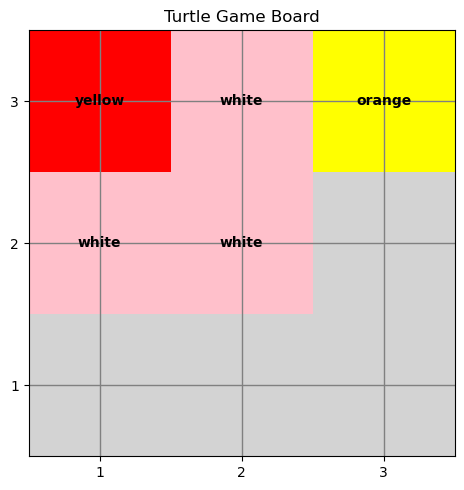

Find white pairs!
Fill in white turtle


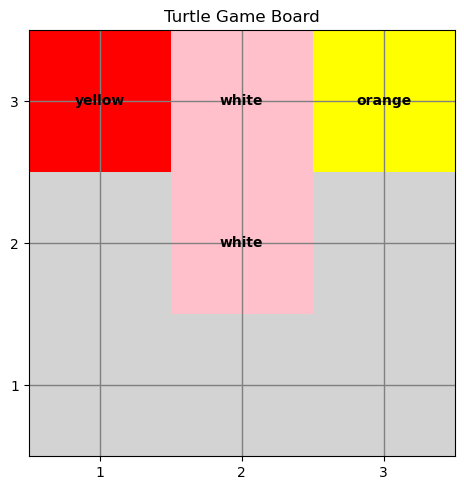

Find white pairs!
Fill in white turtle


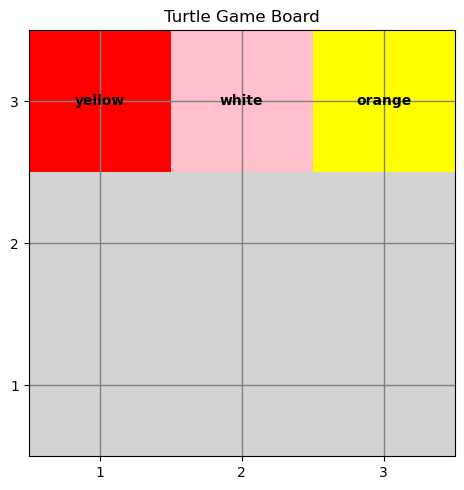

Player lost!


In [4]:
if __name__ == "__main__":
    game = TurtleGame()
    x = int(input("Enter the number of turtles (3-30): "))
    y = input("Enter your lucky color (red, blue, green, yellow, purple, orange, pink, white, black): ").lower()
    game.initialize_game(x, y)
    turtle_used = game.play_game()
    print(game.determine_winner(x))

# **Part III: Color Turtle Battle**

1. Initially you and AI both have 6 random turtle from the turtle pool.
2. 

In [33]:
import numpy as np
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
import random

@dataclass
class GameState:
    board: List[Optional[str]]  # 3x3 board
    current_player_turtles: List[str]  # Current player's turtles
    opponent_turtles: List[str]  # Opponent's turtles
    current_player_secret: str  # Current player's secret color
    opponent_secret: str  # Opponent's secret color
    current_player_id: int  # 0 or 1 to track whose turn it is

    @property
    def current_player_count(self) -> int:
        return len(self.current_player_turtles)
    
    @property
    def opponent_count(self) -> int:
        return len(self.opponent_turtles)

In [67]:
# ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'cyan', 'brown']
class TurtleGameEnvironment:
    def __init__(self):
        self.colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'cyan', 'brown']
        self.board_size = 9
        self.initial_turtles = 6
    
    def is_valid_move(self, state: GameState, position: int) -> bool:
        """Check if a move is valid."""
        return 0 <= position < self.board_size and state.board[position] is None
    
    def get_valid_moves(self, state: GameState) -> List[int]:
        """Get list of valid move positions."""
        return [i for i, cell in enumerate(state.board) if cell is None]
    
    def get_next_empty_position(self, board: List[Optional[str]]) -> Optional[int]:
        """Get the first empty position in the board."""
        for i, cell in enumerate(board):
            if cell is None:
                return i
        return None
    
    def reset(self) -> GameState:
        """Initialize a new game state."""
        # Generate random turtles for both players
        all_colors = self.colors * 2  # Double the colors to have enough
        player1_turtles = random.sample(all_colors, self.initial_turtles)
        player2_turtles = random.sample(all_colors, self.initial_turtles)
        
        # Assign secret colors
        player1_secret = random.choice(self.colors)
        remaining_colors = [c for c in self.colors if c != player1_secret]
        player2_secret = random.choice(remaining_colors)
        
        return GameState(
            board=[None] * self.board_size,
            current_player_turtles=player1_turtles,
            opponent_turtles=player2_turtles,
            current_player_secret=player1_secret,
            opponent_secret=player2_secret,
            current_player_id=0
        )
    
    def step(self, state: GameState, chosen_color: str) -> Tuple[GameState, float, bool, dict]:
        """Execute a move and return new state, reward, done, and info."""
        # Find next empty position
        position = self.get_next_empty_position(state.board)
        if position is None:
            return state, -10, True, {'error': 'No empty positions'}
        
        # Make copy of current state
        new_board = state.board.copy()
        new_current_turtles = state.current_player_turtles.copy()
        new_opponent_turtles = state.opponent_turtles.copy()
        
        # Remove chosen turtle from current player's hand
        if chosen_color not in new_current_turtles:
            return state, -10, True, {'error': 'Invalid turtle color'}
        new_current_turtles.remove(chosen_color)
        
        # Place turtle and check for special conditions
        new_board[position] = chosen_color
        removed_positions = []
        opponent_bonus = 0
        
        # Check if matches opponent's secret color
        if chosen_color == state.opponent_secret:
            removed_positions.append(position)
            opponent_bonus += 1
        else:
            # Check for matching color pairs
            for i, cell in enumerate(new_board):
                if i != position and cell == chosen_color:
                    removed_positions.extend([i, position])
                    opponent_bonus += 1
                    break
        
        # Remove matched turtles
        for pos in removed_positions:
            new_board[pos] = None
        
        # Add bonus turtles to opponent
        for _ in range(opponent_bonus):
            bonus_color = random.choice(self.colors)
            new_opponent_turtles.append(bonus_color)
        
        # Check game over conditions
        game_over = (
            len(new_current_turtles) == 0 or  # Current player out of turtles
            self.get_next_empty_position(new_board) is None  # Board is full
        )
        
        # Calculate reward
        reward = self._calculate_reward(
            len(new_current_turtles),
            len(new_opponent_turtles),
            game_over
        )
        
        # Switch players
        new_state = GameState(
            board=new_board,
            current_player_turtles=new_opponent_turtles,
            opponent_turtles=new_current_turtles,
            current_player_secret=state.opponent_secret,
            opponent_secret=state.current_player_secret,
            current_player_id=1 - state.current_player_id
        )
        
        info = {
            'position': position,
            'removed_positions': removed_positions,
            'opponent_bonus': opponent_bonus,
            'game_over': game_over
        }
        
        return new_state, reward, game_over, info
    
    def _calculate_reward(self, current_turtles: int, opponent_turtles: int, game_over: bool) -> float:
        """Calculate reward based on game state."""
        if not game_over:
            return 0
            
        if current_turtles == 0:  # Lost by running out of turtles
            return -10
        elif current_turtles > opponent_turtles:  # Won with more turtles
            return 10
        else:  # Lost with fewer turtles
            return -10

In [69]:
class QLearningAgent:
    def __init__(self, learning_rate=0.1, discount_factor=0.9, exploration_rate=0.2):
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.q_table: Dict[str, Dict[str, float]] = {}  # Changed to use color as action
        
    def hash_state(self, state: GameState) -> str:
        """Convert game state to string representation."""
        board_str = ''.join([
            'E' if cell is None else
            'P' if cell == state.current_player_secret else
            'A' if cell == state.opponent_secret else 'O'
            for cell in state.board
        ])
        return f"{board_str}-{len(state.current_player_turtles)}-{len(state.opponent_turtles)}"
    
    def get_q_value(self, state_hash: str, color: str) -> float:
        """Get Q-value for state-action pair."""
        if state_hash not in self.q_table:
            self.q_table[state_hash] = {}
        if color not in self.q_table[state_hash]:
            self.q_table[state_hash][color] = 0.0
        return self.q_table[state_hash][color]
    
    def choose_action(self, state: GameState) -> str:
        """Choose color using epsilon-greedy strategy."""
        if random.random() < self.exploration_rate:
            return random.choice(state.current_player_turtles)
            
        # Exploit: choose best color based on Q-values
        state_hash = self.hash_state(state)
        q_values = {
            color: self.get_q_value(state_hash, color)
            for color in state.current_player_turtles
        }
        
        if not q_values:
            return random.choice(state.current_player_turtles)
            
        return max(q_values.items(), key=lambda x: x[1])[0]
    
    def update(self, state: GameState, color: str, reward: float, next_state: GameState, done: bool):
        """Update Q-values based on experience."""
        state_hash = self.hash_state(state)
        next_state_hash = self.hash_state(next_state)
        
        current_q = self.get_q_value(state_hash, color)
        
        if done:
            next_max_q = 0
        else:
            next_q_values = [
                self.get_q_value(next_state_hash, c)
                for c in next_state.current_player_turtles
            ]
            next_max_q = max(next_q_values) if next_q_values else 0
        
        # Q-learning update
        new_q = current_q + self.learning_rate * (
            reward + self.discount_factor * next_max_q - current_q
        )
        
        if state_hash not in self.q_table:
            self.q_table[state_hash] = {}
        self.q_table[state_hash][color] = new_q

In [71]:
class Trainer:
    def __init__(self, env: TurtleGameEnvironment, agent: QLearningAgent):
        self.env = env
        self.agent = agent
        self.stats = {
            'games_played': 0,
            'ai_wins': 0,
            'win_rate': 0.0,
            'rewards': []
        }
    
    def train(self, num_episodes: int, verbose: bool = False):
        """Train the agent for specified number of episodes."""
        for episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            done = False
            
            while not done:
                # AI turn
                color = self.agent.choose_action(state)
                
                # Make move and get results
                next_state, reward, done, info = self.env.step(state, color)
                
                # Update agent
                self.agent.update(state, color, reward, next_state, done)
                
                total_reward += reward
                state = next_state
            
            # Update statistics
            self.stats['games_played'] += 1
            if total_reward > 0:
                self.stats['ai_wins'] += 1
            self.stats['win_rate'] = (self.stats['ai_wins'] / self.stats['games_played']) * 100
            self.stats['rewards'].append(total_reward)
            
            if verbose and episode % 100 == 0:
                print(f"Episode {episode}, Win Rate: {self.stats['win_rate']:.2f}%")

In [77]:
def play_game(env: TurtleGameEnvironment, agent: QLearningAgent = None, human_player: bool = True):
    """Play an interactive game."""
    state = env.reset()
    done = False
    
    print("Game started!")
    print("Player 1 secret color:", state.current_player_secret)
    print("Player 2 secret color:", state.opponent_secret)
    
    while not done:
        print("\nCurrent board:")
        print_board(state.board)
        print(f"\nPlayer {state.current_player_id + 1}'s turn")
        print("Available turtles:", state.current_player_turtles)
        
        if human_player and state.current_player_id == 1:
            # Human player's turn
            while True:
                color = input("Choose turtle color: ").lower()
                if color in state.current_player_turtles:
                    break
                print("Invalid color! Choose from:", state.current_player_turtles)
        else:
            # AI player's turn
            if agent:
                color = agent.choose_action(state)
            else:
                color = random.choice(state.current_player_turtles)
            print(f"AI chooses: {color}")
        
        # Make move
        state, reward, done, info = env.step(state, color)
        
        # Print move results
        print(f"Placed at position: {info['position']}")
        if info['removed_positions']:
            print("Removed turtles at positions:", info['removed_positions'])
        if info['opponent_bonus']:
            print(f"Opponent gained {info['opponent_bonus']} turtle(s)")
    
    # Game over
    print("\nGame Over!")
    print("Final board:")
    print_board(state.board)
    print(f"Player 1 turtles: {len(state.opponent_turtles)}")
    print(f"Player 2 turtles: {len(state.current_player_turtles)}")
    winner = 1 if len(state.opponent_turtles) > len(state.current_player_turtles) else 2
    print(f"Player {winner} wins!")

In [79]:
def print_board(board: List[Optional[str]]):
    """Print the game board."""
    for i in range(0, 9, 3):
        print(" | ".join(str(cell or '_') for cell in board[i:i+3]))
        if i < 6:
            print("-" * 11)

if __name__ == "__main__":
    # Create environment and agent
    env = TurtleGameEnvironment()
    agent = QLearningAgent()
    
    # Create trainer and train agent
    trainer = Trainer(env, agent)
    trainer.train(1000, verbose=True)
    
    # Play a game
    play_game(env, agent, human_player=True)

Episode 0, Win Rate: 0.00%
Episode 100, Win Rate: 0.00%
Episode 200, Win Rate: 0.00%
Episode 300, Win Rate: 0.00%
Episode 400, Win Rate: 0.00%
Episode 500, Win Rate: 0.00%
Episode 600, Win Rate: 0.00%
Episode 700, Win Rate: 0.00%
Episode 800, Win Rate: 0.00%
Episode 900, Win Rate: 0.00%
Game started!
Player 1 secret color: red
Player 2 secret color: yellow

Current board:
_ | _ | _
-----------
_ | _ | _
-----------
_ | _ | _

Player 1's turn
Available turtles: ['pink', 'blue', 'red', 'orange', 'yellow', 'green']
AI chooses: orange
Placed at position: 0

Current board:
orange | _ | _
-----------
_ | _ | _
-----------
_ | _ | _

Player 2's turn
Available turtles: ['blue', 'cyan', 'cyan', 'pink', 'yellow', 'purple']


Choose turtle color:  blue


Placed at position: 1

Current board:
orange | blue | _
-----------
_ | _ | _
-----------
_ | _ | _

Player 1's turn
Available turtles: ['pink', 'blue', 'red', 'yellow', 'green']
AI chooses: pink
Placed at position: 2

Current board:
orange | blue | pink
-----------
_ | _ | _
-----------
_ | _ | _

Player 2's turn
Available turtles: ['cyan', 'cyan', 'pink', 'yellow', 'purple']


Choose turtle color:  cyan


Placed at position: 3

Current board:
orange | blue | pink
-----------
cyan | _ | _
-----------
_ | _ | _

Player 1's turn
Available turtles: ['blue', 'red', 'yellow', 'green']
AI chooses: blue
Placed at position: 4
Removed turtles at positions: [1, 4]
Opponent gained 1 turtle(s)

Current board:
orange | _ | pink
-----------
cyan | _ | _
-----------
_ | _ | _

Player 2's turn
Available turtles: ['cyan', 'pink', 'yellow', 'purple', 'green']


Choose turtle color:  yellpw


Invalid color! Choose from: ['cyan', 'pink', 'yellow', 'purple', 'green']


Choose turtle color:  yellow


Placed at position: 1

Current board:
orange | yellow | pink
-----------
cyan | _ | _
-----------
_ | _ | _

Player 1's turn
Available turtles: ['red', 'yellow', 'green']
AI chooses: red
Placed at position: 4

Current board:
orange | yellow | pink
-----------
cyan | red | _
-----------
_ | _ | _

Player 2's turn
Available turtles: ['cyan', 'pink', 'purple', 'green']


Choose turtle color:  purple


Placed at position: 5

Current board:
orange | yellow | pink
-----------
cyan | red | purple
-----------
_ | _ | _

Player 1's turn
Available turtles: ['yellow', 'green']
AI chooses: yellow
Placed at position: 6
Removed turtles at positions: [6]
Opponent gained 1 turtle(s)

Current board:
orange | yellow | pink
-----------
cyan | red | purple
-----------
_ | _ | _

Player 2's turn
Available turtles: ['cyan', 'pink', 'green', 'blue']


Choose turtle color:  green


Placed at position: 6

Current board:
orange | yellow | pink
-----------
cyan | red | purple
-----------
green | _ | _

Player 1's turn
Available turtles: ['green']
AI chooses: green
Placed at position: 7
Removed turtles at positions: [6, 7]
Opponent gained 1 turtle(s)

Game Over!
Final board:
orange | yellow | pink
-----------
cyan | red | purple
-----------
_ | _ | _
Player 1 turtles: 0
Player 2 turtles: 4
Player 2 wins!
